In [272]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
%autoreload 2

In [521]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
from pylab import plot, show, savefig
from scipy import stats
#%pylab inline

In [931]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-03-10/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 1262
files_end = 1346


In [858]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles1
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "126"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles1_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124"], ["117", "118", "119", "122", "124"]]
isotopes = [["112", "114", "115", "116", "117", "118", "119", "122", "124"]]
#isotopes = [["116", "117", "118", "119", "122", "124"]]
denom_isotope = "120"
isotope_column = ["112", "114", "115", "116", "117", "118", "119", "122", "124"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
print data_sample_column
#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = False

blk_corr = False

['112/120', '114/120', '115/120', '116/120', '117/120', '118/120', '119/120', '122/120', '124/120']


In [932]:
columns_1 = ["cycle", "sample", "date", "H9 (1)", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
#columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
for sample in files_1:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    #df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    #df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    #df_zero_2 = df_zero_2[columns_2]
    #df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "teflon blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)
df_all
#for x in [123]:
#    sample_ls.remove(x)
#blk_ls

,cycle,sample,H9 (1),H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),Ax (1),L1 (1),L2 (1),L3 (1),L4 (1)
date,,,,,,,,,,,,,,,,
2015-03-10 18:49:00,1,NIST 100ppb,-0.002269,1.958211,1.525272,10.442619,2.712433,7.541119,2.354572,4.397220,0.100493,0.193700,0.000167,0.277660,1.077588e-04,0.000161
2015-03-10 18:49:00,2,NIST 100ppb,-0.002259,1.934735,1.506998,10.316683,2.679782,7.449846,2.325987,4.343649,0.099236,0.191387,0.000163,0.274313,1.349823e-04,0.000173
2015-03-10 18:49:00,3,NIST 100ppb,-0.002284,1.922225,1.497336,10.251057,2.662940,7.403081,2.311552,4.316817,0.098670,0.190182,0.000141,0.272580,1.401495e-04,0.000153
2015-03-10 18:49:00,4,NIST 100ppb,-0.002251,1.937404,1.509081,10.330465,2.683645,7.460252,2.329360,4.350302,0.099421,0.191706,0.000146,0.274690,1.433952e-04,0.000152
2015-03-10 18:49:00,5,NIST 100ppb,-0.002280,1.886554,1.469408,10.057411,2.612105,7.261867,2.267190,4.233487,0.096720,0.186491,0.000147,0.267235,1.528485e-04,0.000155
2015-03-10 18:49:00,6,NIST 100ppb,-0.002282,1.951857,1.520256,10.406777,2.703451,7.515025,2.346538,4.382155,0.100146,0.193029,0.000143,0.276736,1.391308e-04,0.000155
2015-03-10 18:49:00,7,NIST 100ppb,-0.002261,1.923546,1.498482,10.258344,2.664767,7.408416,2.313287,4.319888,0.098711,0.190302,0.000154,0.272816,1.107864e-04,0.000152
2015-03-10 18:49:00,8,NIST 100ppb,-0.002261,1.898826,1.479219,10.127090,2.630674,7.313535,2.283633,4.264203,0.097488,0.187821,0.000146,0.269317,1.330022e-04,0.000150
2015-03-10 18:49:00,9,NIST 100ppb,-0.002279,1.883766,1.467191,10.043487,2.608967,7.252616,2.264561,4.229125,0.096654,0.186254,0.000154,0.267002,1.408182e-04,0.000185


In [933]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    #blk1 = [item for item in blk_ls if item < sample]
    #blk2 = [item for item in blk_ls if item > sample]
    #blk1 = blk1[-1]
    #blk2 = blk2[0]
    #blk_corr_sample == True
    
    # blank measurement surrounds sample
    if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
        blk1 = sample-1
        blk2 = sample+1
        blk_corr_sample = True
    else:
        blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_1 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_1 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = data_sample_raw[np.abs(data_sample_raw-data_sample_raw.mean())<=(2*data_sample_raw.std())]
    
    data_sample = new_corr.internal_norm_1(denom_isotope, 10)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = data_sample[np.abs(data_sample-data_sample.mean())<=(2*data_sample.std())]
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)

In [934]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)
df_internal_sub
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

,cycle,sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,112,114,115,116,117,118,119,120,122,124
date,,,,,,,,,,,,,,,,,,,,,
2015-03-10 18:49:00,1,NIST 100ppb,0.029866,0.020209,0.010343,0.446,0.235367,0.743035,0.263455,0.142049,...,0.277660,0.193700,0.100493,4.397220,2.354572,7.541119,2.712433,10.442619,1.525272,1.958211
2015-03-10 18:49:00,2,NIST 100ppb,0.029868,0.020208,0.010340,0.446,0.235370,0.743049,0.263469,0.142052,...,0.274313,0.191387,0.099236,4.343649,2.325987,7.449846,2.679782,10.316683,1.506998,1.934735
2015-03-10 18:49:00,3,NIST 100ppb,0.029857,0.020203,0.010345,0.446,0.235375,0.743044,0.263477,0.142058,...,0.272580,0.190182,0.098670,4.316817,2.311552,7.403081,2.662940,10.251057,1.497336,1.922225
2015-03-10 18:49:00,4,NIST 100ppb,0.029856,0.020207,0.010343,0.446,0.235363,0.743023,0.263484,0.142072,...,0.274690,0.191706,0.099421,4.350302,2.329360,7.460252,2.683645,10.330465,1.509081,1.937404
2015-03-10 18:49:00,5,NIST 100ppb,0.029858,0.020201,0.010341,0.446,0.235377,0.743060,0.263451,0.142063,...,0.267235,0.186491,0.096720,4.233487,2.267190,7.261867,2.612105,10.057411,1.469408,1.886554
2015-03-10 18:49:00,6,NIST 100ppb,0.029863,0.020200,0.010343,0.446,0.235371,0.743013,0.263487,0.142070,...,0.276736,0.193029,0.100146,4.382155,2.346538,7.515025,2.703451,10.406777,1.520256,1.951857
2015-03-10 18:49:00,7,NIST 100ppb,0.029868,0.020208,0.010342,0.446,0.235383,0.743050,0.263471,0.142066,...,0.272816,0.190302,0.098711,4.319888,2.313287,7.408416,2.664767,10.258344,1.498482,1.923546
2015-03-10 18:49:00,8,NIST 100ppb,0.029868,0.020200,0.010347,0.446,0.235395,0.743077,0.263477,0.142050,...,0.269317,0.187821,0.097488,4.264203,2.283633,7.313535,2.630674,10.127090,1.479219,1.898826
2015-03-10 18:49:00,9,NIST 100ppb,0.029854,0.020195,0.010344,0.446,0.235367,0.743011,0.263477,0.142070,...,0.267002,0.186254,0.096654,4.229125,2.264561,7.252616,2.608967,10.043487,1.467191,1.883766


In [968]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SE])
df_internal_norm_mean["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
df_internal_norm_mean = df_internal_norm_mean[1:]
df_internal_norm_mean = df_internal_norm_mean.drop(datetime.strptime("20150310 23:59", "%Y%m%d %H:%M"))
df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:]
df_internal_norm_mean
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,112,114,115,116,117,118,119,120,122,124,sample
date,,,,,,,,,,,,,,,,,,,,
2015-03-10 19:01:00,0.029830,0.020193,0.010364,0.446,0.235300,0.742914,0.263451,0.142096,0.177585,0.259419,0.180954,0.094257,4.115508,2.203080,7.056573,2.538454,9.772707,1.428090,1.834585,SPEX 100ppb
2015-03-10 19:12:00,0.029827,0.020193,0.010362,0.446,0.235297,0.742907,0.263455,0.142097,0.177590,0.272665,0.190192,0.098953,4.324810,2.314865,7.414000,2.666884,10.266097,1.499942,1.926664,NIST 100ppb
2015-03-10 19:23:00,0.029830,0.020191,0.010366,0.446,0.235301,0.742910,0.263443,0.142091,0.177576,0.258190,0.180080,0.093799,4.096010,2.192627,7.023080,2.526341,9.726321,1.421261,1.825837,SPEX 100ppb
2015-03-10 19:34:00,0.029834,0.020195,0.010361,0.446,0.235299,0.742912,0.263454,0.142098,0.177590,0.261481,0.182356,0.094946,4.146918,2.219713,7.109400,2.557315,9.844429,1.438365,1.847606,NIST 100ppb
2015-03-10 19:45:00,0.029826,0.020193,0.010372,0.446,0.235304,0.742918,0.263458,0.142086,0.177605,0.248970,0.173697,0.090501,3.948842,2.114383,6.771629,2.435663,9.378938,1.370523,1.760388,SPEX 100ppb
2015-03-10 19:57:00,0.029828,0.020194,0.010362,0.446,0.235297,0.742911,0.263455,0.142097,0.177590,0.260612,0.181778,0.094669,4.134062,2.212843,7.087301,2.549350,9.813819,1.433900,1.841843,NIST 100ppb
2015-03-10 20:08:00,0.029832,0.020196,0.010367,0.446,0.235301,0.742924,0.263451,0.142095,0.177583,0.251126,0.175205,0.091260,3.984864,2.133279,6.833165,2.458162,9.463982,1.383093,1.776849,SPEX 100ppb
2015-03-10 20:19:00,0.029833,0.020194,0.010361,0.446,0.235304,0.742909,0.263450,0.142092,0.177580,0.265648,0.185249,0.096456,4.213037,2.255115,7.222798,2.598131,10.001653,1.461345,1.877165,NIST 100ppb
2015-03-10 20:30:00,0.029830,0.020192,0.010370,0.446,0.235304,0.742919,0.263458,0.142097,0.177599,0.254921,0.177838,0.092672,4.045166,2.165504,6.936504,2.495439,9.607213,1.404058,1.804176,SPEX 100ppb


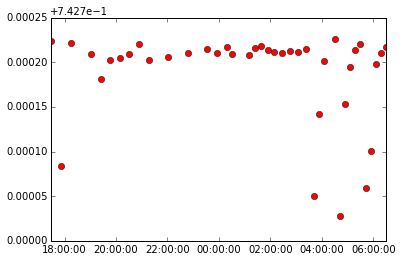

In [553]:
#plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] != "SPEX1 100ppb"]
plot_Nist = df_internal_norm_mean[(df_internal_norm_mean["118"] >= .5)]
dataplot = plot(plot_Nist.index, plot_Nist["118/120"], "ro")
show(dataplot)

In [1034]:
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == "NIST 100ppb")].index
#corr_values = df_internal_norm_mean[(df_external_norm_mean >= 0.74289)]
#corr_values = df_internal_norm_mean[:"20150110 10:00"]
corr_values = df_std
sample = corr_values["sample"]
std_mean = corr_values[(corr_values["sample"] == "SPEX 100ppb")].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
#epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
#epsilon_2 = ((new / ((new.shift(2) + new.shift(-2))/2))-1)*10000
#epsilon["sample"] = sample
epsilon["sample"] = sample

#epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#new[new.sample != "NIST 100ppb"]
#epsilon2 = epsilon_2.ix[2:-4,:][epsilon_2["sample"] == "SPEX 100ppb"]
#epsilon_comp = epsilon.append(epsilon2, ignore_index=True)
epsilon

/Users/marf/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,sample
2,SPEX 100ppb
4,SPEX 100ppb
6,SPEX 100ppb
8,SPEX 100ppb
13,NIST 100ppb
14,NIST 100ppb
15,NIST 100ppb
16,NIST 100ppb
17,NIST 100ppb
18,NIST 100ppb


In [1189]:
def SD2(x):
    SD2 = np.std(x) * 2
    return SD2

#epsilon = epsilon.drop(["112", "114", "115", "116", "117", "118", "119", "120", "122", "124"], axis = 1)
epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2, np.size]), decimals=2)
epsilon_sum

112/120            114/120            115/120            116/120  \
               mean   SD2 size    mean   SD2 size    mean   SD2 size    mean   
sample                                                                         
NIST 100ppb   -0.01  3.24  127   -0.02  4.82  127   -7.23  2.53  127       0   
SPEX 100ppb    0.00  3.82  174    0.00  5.32  174    0.00  3.11  174       0   

            ...  118/120 119/120            122/120            124/120        \
            ...     size    mean   SD2 size    mean   SD2 size    mean   SD2   
sample      ...                                                                
NIST 100ppb ...      127    0.04  0.63  127   -0.21  0.89  127   -0.54  1.96   
SPEX 100ppb ...      174    0.00  0.90  174   -0.00  1.25  174    0.00  2.65   

                  
            size  
sample            
NIST 100ppb  127  
SPEX 100ppb  174  

[2 rows x 27 columns]

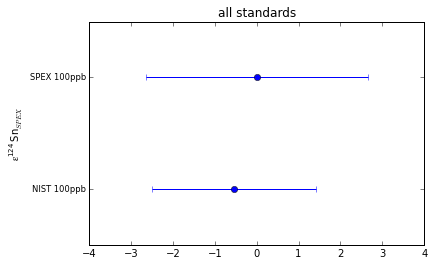

In [1202]:
x = range(1, len(epsilon_sum.index)+1)
errorbar(epsilon_sum["124/120"]["mean"], x, xerr = epsilon_sum["124/120"]["SD2"], ls='none', marker="o")
title("all standards")
xlim([-4, 4])
ylim([0.5, 2.5])
yticks(x, epsilon_sum.index, size='small', rotation=0)
ylabel(r'$\mathregular{\epsilon^{124}}$Sn$_{SPEX}$')
savefig(path_sav+"epsilon_124_stds.pdf", bbox_inches='tight')

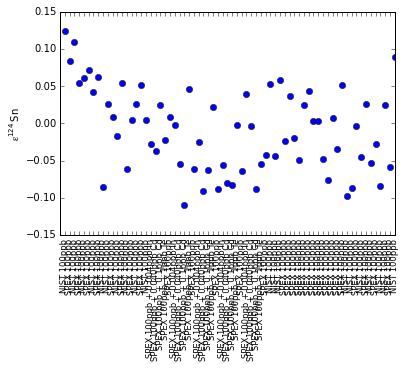

In [659]:
x = range(1, len(epsilon["sample"])+1)
plot(x, epsilon["118/120"], marker="o", ls="none")
xticks(x, epsilon["sample"], size='small', rotation=90)
ylabel(r'$\mathregular{\epsilon^{124}}$Sn')
#savefig(path+"epsilon_119.pdf", bbox_inches='tight')

In [980]:
df_all.to_csv(path_sav + "Sn_H9_L4_1_cycles_NU_Signals_zero_corr.csv", mode='a', header=False)

In [981]:
df_internal_sub.to_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm.csv", mode='a', header=False)

In [985]:
df_internal_norm_mean_sd.to_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv", mode='a', header=False)

In [1226]:
df_std.to_csv(path_sav + "All_standards_internal_norm_mean.csv")

In [986]:
df_all_mean_1 = pd.read_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv")

In [987]:
df_all_mean_2 = pd.read_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm_mean.csv")

In [1088]:
df_mean_all = df_all_mean_1.append(df_all_mean_2)

In [1089]:
df_mean_all = df_mean_all[2:]
df_mean_all.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
df_mean_all = df_mean_all[["Date", "112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118","sample"]]
df_mean_all = df_mean_all.set_index("Date") 

In [1182]:
df_std = df_mean_all[(df_mean_all["sample"] == "SPEX1 100ppb") | (df_mean_all["sample"] == "SPEX 100ppb") | (df_mean_all["sample"] == "NIST 100ppb")]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 20:49:00,0.0298238495726,0.0201845997439,0.0103681594438,0.446,0.235295696368,0.742939518097,0.263445942562,0.142086185109,0.177571556759,10.1619395381,SPEX1 100ppb
2014-10-07 21:07:00,0.0298270855009,0.0201887834143,0.0103664239291,0.446,0.235295260593,0.742937654621,0.263447680516,0.14208571056,0.177573088542,10.2834847296,SPEX1 100ppb
2014-10-07 21:29:00,0.0298241010738,0.0201850728708,0.0103667030734,0.446,0.235295046713,0.742937732217,0.263449417694,0.142085954225,0.17757007419,10.0068814188,SPEX1 100ppb
2014-10-07 21:46:00,0.0298269719657,0.0201827454973,0.0103676568054,0.446,0.235297077525,0.742936157145,0.263450048386,0.142089277895,0.177573191934,10.1732362802,SPEX1 100ppb
2014-11-18 18:22:00,0.0298319477344,0.0201968060654,0.0103609914838,0.446,0.235308007067,0.74295144542,0.263456437295,0.142073025422,0.17753393783,11.9205622223,NIST 100ppb
2014-11-18 18:27:00,0.0298302415426,0.0202014506204,0.0103609667001,0.446,0.235304600881,0.742949759778,0.263451222795,0.142074064497,0.177531032284,11.8435340427,NIST 100ppb
2014-11-18 18:31:00,0.029834566445,0.0202024281122,0.0103608586407,0.446,0.235309236679,0.742955467382,0.263452936054,0.142073215452,0.177533064574,11.3634385069,NIST 100ppb
2014-11-18 18:36:00,0.0298236482085,0.0201946006554,0.0103617565758,0.446,0.235308318118,0.742946848523,0.263449990275,0.142074569672,0.177530832831,11.5416992302,NIST 100ppb
2014-11-18 18:40:00,0.0298227478429,0.0201921659888,0.0103615705949,0.446,0.235307461611,0.742950591745,0.263450041891,0.142075223065,0.177536326791,11.6314409578,NIST 100ppb


In [1183]:
df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]] = df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]].astype(float)
df_std.index = df_std.index.astype(datetime64)
df_std = df_std[(df_std.index < pd.Timestamp('2015-03-10')) | (df_std.index > pd.Timestamp('2015-03-12'))]
df_std = df_std[(df_std.index < pd.Timestamp('2014-11-29 18:25:00')) | (df_std.index > pd.Timestamp('2014-11-29 20:27:00'))]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 18:49:00,0.029824,0.020185,0.010368,0.446,0.235296,0.742940,0.263446,0.142086,0.177572,10.161940,SPEX1 100ppb
2014-10-07 19:07:00,0.029827,0.020189,0.010366,0.446,0.235295,0.742938,0.263448,0.142086,0.177573,10.283485,SPEX1 100ppb
2014-10-07 19:29:00,0.029824,0.020185,0.010367,0.446,0.235295,0.742938,0.263449,0.142086,0.177570,10.006881,SPEX1 100ppb
2014-10-07 19:46:00,0.029827,0.020183,0.010368,0.446,0.235297,0.742936,0.263450,0.142089,0.177573,10.173236,SPEX1 100ppb
2014-11-18 17:22:00,0.029832,0.020197,0.010361,0.446,0.235308,0.742951,0.263456,0.142073,0.177534,11.920562,NIST 100ppb
2014-11-18 17:27:00,0.029830,0.020201,0.010361,0.446,0.235305,0.742950,0.263451,0.142074,0.177531,11.843534,NIST 100ppb
2014-11-18 17:31:00,0.029835,0.020202,0.010361,0.446,0.235309,0.742955,0.263453,0.142073,0.177533,11.363439,NIST 100ppb
2014-11-18 17:36:00,0.029824,0.020195,0.010362,0.446,0.235308,0.742947,0.263450,0.142075,0.177531,11.541699,NIST 100ppb
2014-11-18 17:40:00,0.029823,0.020192,0.010362,0.446,0.235307,0.742951,0.263450,0.142075,0.177536,11.631441,NIST 100ppb


In [1184]:
df_std = df_std[(df_std["118"] > 5) & (df_std["118/120"] > 0.7428)]
for i in df_std.index[df_std["sample"] == "SPEX1 100ppb"]:
    df_std.ix[i, "sample"] = "SPEX 100ppb"

In [1220]:
sample = df_std["sample"]
std_mean = df_std[(df_std["sample"] == "SPEX 100ppb")].mean()
new = df_std[df_std.columns[df_std.dtypes != 'object']]
epsilon =  ((new / std_mean)-1)*10000
epsilon["sample"] = sample
epsilon
epsilon[(epsilon["118/120"] > 0.4) | (epsilon["118/120"] < -0.4)]

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-11-18 18:54:00,-1.295126,-1.053575,1.608025,1.998401e-11,-1.180555,-0.463371,-0.356364,0.722133,2.010156,1309.494419,SPEX 100ppb
2014-12-06 22:37:00,-4.936059,-7.445774,1.331682,1.998401e-11,0.786625,0.539985,1.003885,0.222717,0.767402,-1614.119882,SPEX 100ppb
2014-12-06 22:52:00,-1.620072,-3.896472,0.536870,1.998401e-11,0.533814,0.527568,1.004705,0.469725,1.664357,-1804.778746,SPEX 100ppb
2014-12-06 23:08:00,-2.641746,-4.386719,2.125820,1.998401e-11,0.522416,0.475452,0.892735,0.462190,1.555222,-1848.039153,SPEX 100ppb
2014-12-06 23:23:00,-3.243182,-3.908338,-0.299309,1.998401e-11,0.613841,0.489401,0.951723,0.466426,1.660720,-1728.263406,SPEX 100ppb
2014-12-06 23:39:00,-3.174104,-5.626922,2.187946,1.998401e-11,0.711496,0.500329,0.913301,0.302836,1.500547,-1512.382276,SPEX 100ppb
2014-12-06 23:54:00,-2.499252,-3.686348,3.196847,1.998401e-11,0.532245,0.565307,0.943385,0.268384,1.570411,-1442.654967,SPEX 100ppb
2014-12-07 00:09:00,-3.167063,-4.997893,0.608021,1.998401e-11,0.745353,0.520016,1.039127,0.455542,1.559710,-1523.698889,SPEX 100ppb
2014-12-07 00:25:00,-2.027759,-4.105014,2.820000,1.998401e-11,0.605650,0.507195,0.913818,0.470145,1.538801,-1719.373397,SPEX 100ppb


In [1222]:
lee = pd.DataFrame({"112/120" : pd.Series(0.029812), "114/120" : pd.Series(0.020195), "115/120": pd.Series(0.010366), "116/120": pd.Series(0.4460), "117/120" : pd.Series(0.235313), "118/120" : pd.Series(0.742935), "119/120" : pd.Series(0.263430), "122/120" : pd.Series(0.142086), "124/120" : pd.Series(0.177588)})
epsilon_lee = ((lee / std_mean[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]])-1)*10000
epsilon_lee["sample"] = "Lee et al. (1995)"
epsilon_lee

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,sample
0,-4.252887,1.76055,-2.836398,1.998401e-11,0.6046,0.052729,-0.550984,0.411199,1.946529,Lee et al. (1995)
